In [2]:
#!/usr/bin/env python3
"""
detectree2_pipeline.py

A clean, organized script to:
1. Tile up a large orthomosaic.
2. Load a pre-trained detectree2 model.
3. Run predictions on each tile.
4. Convert tile predictions to GeoJSON.
5. Stitch those individual predictions into a single shapefile/GeoPackage.
6. Clean overlapping polygons.
7. (Optional) Plot and visualize results.

Make sure you have detectree2, detectron2, rasterio, geopandas, and matplotlib installed.
"""
import warnings
warnings.filterwarnings('ignore')

import os
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt

# Detectree2 imports
from detectree2.preprocessing.tiling import tile_data
from detectree2.models.train import MyTrainer, setup_cfg
from detectree2.models.predict import predict_on_data
from detectron2.engine import DefaultPredictor
from detectree2.models.outputs import project_to_geojson, stitch_crowns, clean_crowns
from rasterio.plot import show

def run_detectree_pipeline(
    img_path: str,
    tiles_path: str,
    trained_model_path: str,
    output_crowns_path: str,
    tile_width: float = 10,
    tile_height: float = 10,
    buffer: float = 20,
    iou_threshold: float = 0.7,
    confidence_threshold: float = 0.5,
    do_plot: bool = True
):
    """
    Runs the detectree2 pipeline on a single large orthomosaic.

    Parameters
    ----------
    img_path : str
        Path to the input orthomosaic .tif file.
    tiles_path : str
        Folder path to store the tiled images and predictions.
    trained_model_path : str
        Path to the pre-trained Detectree2 model (.pth).
    output_crowns_path : str
        File path for saving the final stitched/cleaned crowns. Should end with .gpkg or .shp.
    tile_width : float, optional
        The width in map units (meters, if your orthomosaic is georeferenced in a meter-based CRS) of each tile.
    tile_height : float, optional
        The height in map units of each tile.
    buffer : float, optional
        Overlap buffer (in the same map units) between tiles to mitigate edge effects.
    iou_threshold : float, optional
        IoU threshold for cleaning large overlaps between predicted crowns.
    confidence_threshold : float, optional
        Confidence threshold for the final cleaning. 
        Typically used by detectree2's `clean_crowns` to keep only the most confident crown when overlaps exceed iou_threshold.
    do_plot : bool, optional
        If True, plots the final crowns and the orthomosaic for quick visualization.
    """

    # 1. Tiling the orthomosaic
    print("Tiling the orthomosaic...")
    tile_data(
        img_path=img_path,
        out_dir=tiles_path,
        buffer=buffer,
        tile_width=tile_width,
        tile_height=tile_height,
        dtype_bool=True, # convert dtype if needed, typically for 8/16-bit images
        multithreaded=True,
        overlapping_tiles=True
    )
    print("Tiling completed.\n")

    # 2. Load configuration with pre-trained model
    print("Setting up detectree2 model configuration...")
    cfg = setup_cfg(update_model=trained_model_path)
    predictor = DefaultPredictor(cfg)
    print("Model configuration loaded.\n")

    # 3. Make predictions on each tile
    print("Running predictions on tiled images...")
    predict_on_data(directory=tiles_path, predictor=predictor)
    print("Predictions completed.\n")

    # 4. Reproject predictions to GeoJSON
    print("Reprojecting tile-level predictions to GeoJSON...")
    predictions_dir = os.path.join(tiles_path, "predictions/")
    predictions_geo_dir = os.path.join(tiles_path, "predictions_geo/")
    os.makedirs(predictions_geo_dir, exist_ok=True)

    project_to_geojson(
        pred_fold=predictions_dir,
        output_fold=predictions_geo_dir,
        tiles_path=tiles_path
    )
    print("Reprojection to GeoJSON done.\n")

    # 5. Stitch predictions into a single output
    print("Stitching predicted crowns...")
    crowns = stitch_crowns(predictions_geo_dir, 1)
    print("Number of predicted polygons (before cleaning):", len(crowns))

    # Remove any invalid geometries
    crowns = crowns[crowns.is_valid]

    # 6. Simplify polygons (optional but recommended to remove geometry noise)
    #    Adjust the tolerance as needed
    crowns = crowns.set_geometry(crowns.simplify(tolerance=0.3))

    # 7. Clean overlapping crowns
    print("Cleaning overlapping polygons with IoU threshold:", iou_threshold)
    crowns_clean = clean_crowns(
        crowns,
        iou_threshold,
        confidence_threshold
    )
    print("Number of predicted polygons (after cleaning):", len(crowns_clean))

    # 8. Save the final cleaned crowns
    print("Saving final crowns to:", output_crowns_path)
    crowns_clean.to_file(output_crowns_path, driver="GPKG" if output_crowns_path.endswith(".gpkg") else None)
    print("Crown GeoDataFrame saved.\n")

    # 9. (Optional) Visualize results
    if do_plot:
        print("Plotting results...")
        try:
            with rasterio.open(img_path) as src:
                fig, ax = plt.subplots(figsize=(10, 10))
                show(src, ax=ax)
                crowns_clean.plot(ax=ax, facecolor='none', edgecolor='red')
                ax.set_title("Orthomosaic with Predicted Crowns")
                plt.show()
        except Exception as e:
            print("Could not plot the orthomosaic and crowns. Error:", str(e))
    print("Pipeline complete.\n")    

Tiling the orthomosaic...


  0%|          | 0/238 [00:00<?, ?it/s]

INFO:detectree2.preprocessing.tiling:Tiling complete


Tiling completed.

Setting up detectree2 model configuration...


INFO:detectron2.checkpoint.detection_checkpoint:[DetectionCheckpointer] Loading from large_files/230103_randresize_full.pth ...
INFO:fvcore.common.checkpoint:[Checkpointer] Loading from large_files/230103_randresize_full.pth ...


Model configuration loaded.

Running predictions on tiled images...
Predicting 175 files in mode rgb
Predicted 50 files of 175
Predicted 100 files of 175
Predicted 150 files of 175
Predictions completed.

Reprojecting tile-level predictions to GeoJSON...
Projecting 175 files
Projecting file 50 of 175: large_files/tiles_sit_om2_230103_randresize_full_50/predictions/Prediction_sit_om2_714342_3159580_20_15_32643.json
Projecting file 100 of 175: large_files/tiles_sit_om2_230103_randresize_full_50/predictions/Prediction_sit_om2_714332_3159570_20_15_32643.json
Projecting file 150 of 175: large_files/tiles_sit_om2_230103_randresize_full_50/predictions/Prediction_sit_om2_714412_3159530_20_15_32643.json
Reprojection to GeoJSON done.

Stitching predicted crowns...
Stitching file 50 of 175: large_files/tiles_sit_om2_230103_randresize_full_50/predictions_geo/Prediction_sit_om2_714392_3159490_20_15_32643.geojson
Stitching file 100 of 175: large_files/tiles_sit_om2_230103_randresize_full_50/predicti

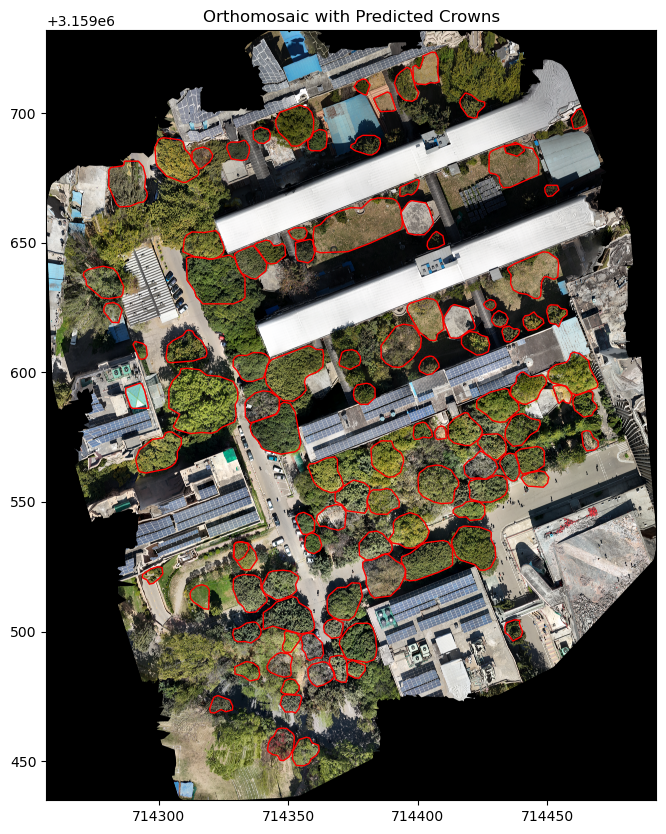

Pipeline complete.



In [3]:
# Example usage with your original file names and paths.
# Customize these paths before running.
SITE_PATH = "large_files/"
IMG_PATH = os.path.join(SITE_PATH, "sit_om2.tif")
TILES_PATH = os.path.join(SITE_PATH, "tiles_sit_om2_230103_randresize_full_50/")
TRAINED_MODEL_PATH = "large_files/230103_randresize_full.pth"
OUTPUT_CROWNS_PATH = os.path.join(TILES_PATH, "crowns_map.gpkg")

run_detectree_pipeline(
    img_path=IMG_PATH,
    tiles_path=TILES_PATH,
    trained_model_path=TRAINED_MODEL_PATH,
    output_crowns_path=OUTPUT_CROWNS_PATH,
    tile_width=20,
    tile_height=20,
    buffer=15,
    iou_threshold=0.6,
    confidence_threshold=0.7,
    do_plot=True
)

Tiling the orthomosaic...


  0%|          | 0/238 [00:00<?, ?it/s]

INFO:detectree2.preprocessing.tiling:Tiling complete


Tiling completed.

Setting up detectree2 model configuration...


INFO:detectron2.checkpoint.detection_checkpoint:[DetectionCheckpointer] Loading from large_files/230103_randresize_full.pth ...
INFO:fvcore.common.checkpoint:[Checkpointer] Loading from large_files/230103_randresize_full.pth ...


Model configuration loaded.

Running predictions on tiled images...
Predicting 175 files in mode rgb
Predicted 50 files of 175
Predicted 100 files of 175
Predicted 150 files of 175
Predictions completed.

Reprojecting tile-level predictions to GeoJSON...
Projecting 175 files
Projecting file 50 of 175: large_files/tiles_sit_om2_230103_randresize_full_5_high_thresholds/predictions/Prediction_sit_om2_714342_3159580_20_15_32643.json
Projecting file 100 of 175: large_files/tiles_sit_om2_230103_randresize_full_5_high_thresholds/predictions/Prediction_sit_om2_714332_3159570_20_15_32643.json
Projecting file 150 of 175: large_files/tiles_sit_om2_230103_randresize_full_5_high_thresholds/predictions/Prediction_sit_om2_714412_3159530_20_15_32643.json
Reprojection to GeoJSON done.

Stitching predicted crowns...
Stitching file 50 of 175: large_files/tiles_sit_om2_230103_randresize_full_5_high_thresholds/predictions_geo/Prediction_sit_om2_714392_3159490_20_15_32643.geojson
Stitching file 100 of 175: 

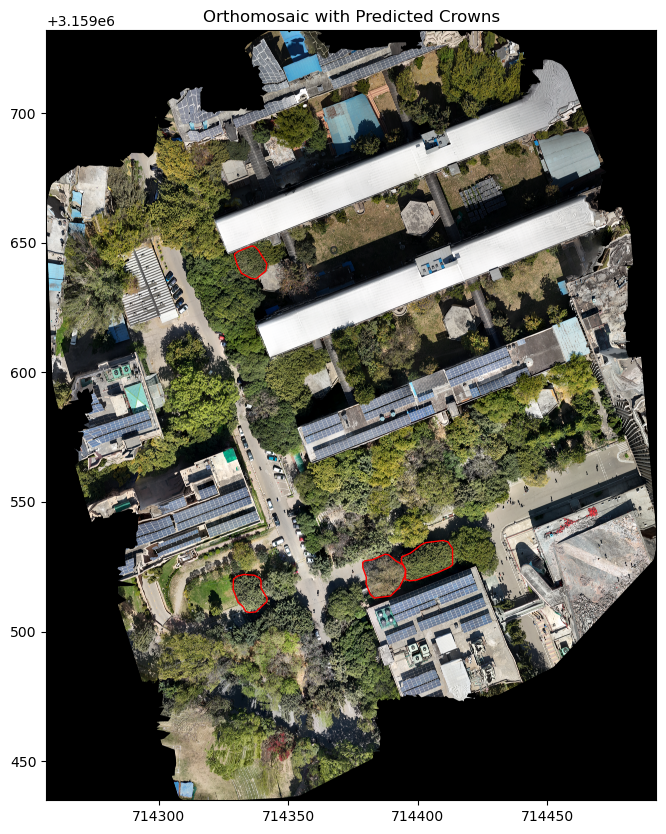

Pipeline complete.



In [7]:
# Example usage with your original file names and paths.
# Customize these paths before running.
SITE_PATH = "large_files/"
IMG_PATH = os.path.join(SITE_PATH, "sit_om2.tif")
TILES_PATH = os.path.join(SITE_PATH, "tiles_sit_om2_230103_randresize_full_5_high_thresholds/")
TRAINED_MODEL_PATH = "large_files/230103_randresize_full.pth"
OUTPUT_CROWNS_PATH = os.path.join(TILES_PATH, "crowns_map.gpkg")

run_detectree_pipeline(
    img_path=IMG_PATH,
    tiles_path=TILES_PATH,
    trained_model_path=TRAINED_MODEL_PATH,
    output_crowns_path=OUTPUT_CROWNS_PATH,
    tile_width=20,
    tile_height=20,
    buffer=15,
    iou_threshold=0.7,
    confidence_threshold=0.9,
    do_plot=True
)

Tiling the orthomosaic...


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:detectree2.preprocessing.tiling:Tiling complete


Tiling completed.

Setting up detectree2 model configuration...


INFO:detectron2.checkpoint.detection_checkpoint:[DetectionCheckpointer] Loading from large_files/urban_trees_Cambridge_20230630.pth ...
INFO:fvcore.common.checkpoint:[Checkpointer] Loading from large_files/urban_trees_Cambridge_20230630.pth ...


Model configuration loaded.

Running predictions on tiled images...
Predicting 5 files in mode rgb
Predictions completed.

Reprojecting tile-level predictions to GeoJSON...
Projecting 5 files
Reprojection to GeoJSON done.

Stitching predicted crowns...
Number of predicted polygons (before cleaning): 431
Cleaning overlapping polygons with IoU threshold: 0.6
Cleaning 429 crowns
0 / 429 crowns cleaned
Number of predicted polygons (after cleaning): 47
Saving final crowns to: large_files/tiles_sit_om2_urban_trees_Cambridge_20230630_100/crowns_map.gpkg
Crown GeoDataFrame saved.

Plotting results...


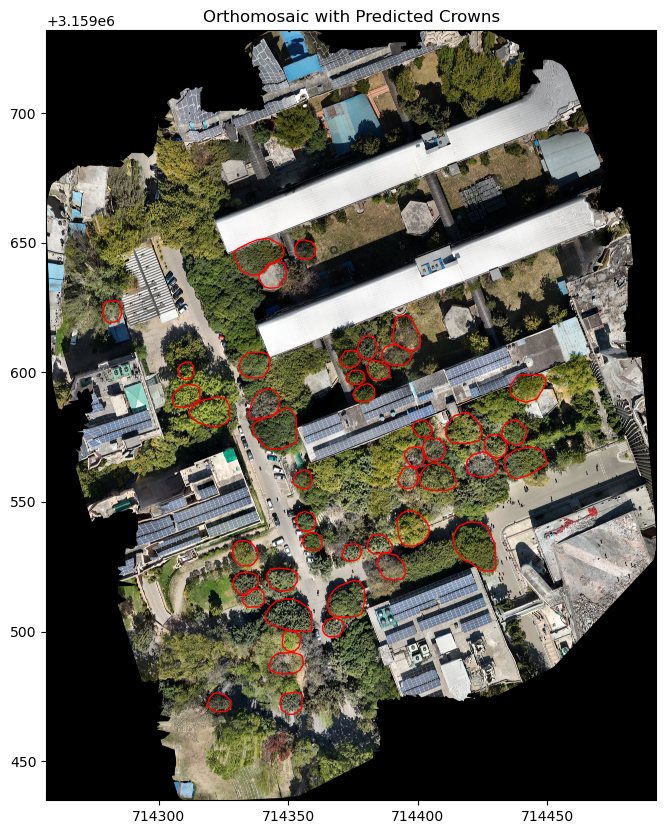

Pipeline complete.



In [6]:
# Example usage with your original file names and paths.
# Customize these paths before running.
SITE_PATH = "large_files/"
IMG_PATH = os.path.join(SITE_PATH, "sit_om2.tif")
TILES_PATH = os.path.join(SITE_PATH, "tiles_sit_om2_urban_trees_Cambridge_20230630_100/")
TRAINED_MODEL_PATH = "large_files/urban_trees_Cambridge_20230630.pth"
OUTPUT_CROWNS_PATH = os.path.join(TILES_PATH, "crowns_map.gpkg")

run_detectree_pipeline(
    img_path=IMG_PATH,
    tiles_path=TILES_PATH,
    trained_model_path=TRAINED_MODEL_PATH,
    output_crowns_path=OUTPUT_CROWNS_PATH,
    tile_width=50,
    tile_height=50,
    buffer=50,
    iou_threshold=0.6,
    confidence_threshold=0.7,
    do_plot=True
)

In [ ]:
#!/usr/bin/env python3
"""
detectree2_pipeline_with_metrics.py

A clean, organized script to:
1. Tile up a large orthomosaic.
2. Load a pre-trained detectree2 model.
3. Run predictions on each tile.
4. Convert tile predictions to GeoJSON.
5. Stitch those individual predictions into a single shapefile/GeoPackage.
6. Clean overlapping polygons.
7. (Optional) Plot and visualize results.
8. (New) If CVAT COCO JSON is provided, compute detection metrics 
   (Precision, Recall, F1, omission error, commission error).
"""

import warnings
warnings.filterwarnings('ignore')

import os
import json
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt

# Detectree2 imports
from detectree2.preprocessing.tiling import tile_data
from detectree2.models.train import MyTrainer, setup_cfg
from detectree2.models.predict import predict_on_data
from detectron2.engine import DefaultPredictor
from detectree2.models.outputs import project_to_geojson, stitch_crowns, clean_crowns

from rasterio.plot import show
from shapely.geometry import Polygon

def run_detectree_pipeline(
    img_path: str,
    tiles_path: str,
    trained_model_path: str,
    output_crowns_path: str,
    tile_width: float = 10,
    tile_height: float = 10,
    buffer: float = 20,
    iou_threshold: float = 0.7,
    confidence_threshold: float = 0.5,
    do_plot: bool = True,
    # (New) Path to CVAT COCO JSON. If provided, we compute detection metrics.
    gt_cvat_json_path: str = None,
    # IoU threshold for counting matches in metrics
    metrics_iou_threshold: float = 0.5
):
    """
    Runs the detectree2 pipeline on a single large orthomosaic. Optionally computes 
    detection metrics if a CVAT COCO JSON is provided.

    Parameters
    ----------
    img_path : str
        Path to the input orthomosaic .tif file.
    tiles_path : str
        Folder path to store the tiled images and predictions.
    trained_model_path : str
        Path to the pre-trained Detectree2 model (.pth).
    output_crowns_path : str
        File path for saving the final stitched/cleaned crowns. 
        Should end with .gpkg or .shp.
    tile_width : float, optional
        The width in map units (meters, if georeferenced in a meter-based CRS) of each tile.
    tile_height : float, optional
        The height in map units of each tile.
    buffer : float, optional
        Overlap buffer (in the same map units) between tiles to mitigate edge effects.
    iou_threshold : float, optional
        IoU threshold for cleaning large overlaps between predicted crowns.
    confidence_threshold : float, optional
        Confidence threshold for removing lower-confidence crowns during cleaning.
    do_plot : bool, optional
        If True, plots the final crowns and the orthomosaic for quick visualization.
    gt_cvat_json_path : str, optional
        If provided (path to your 'instances_default.json'), we parse it as 
        ground-truth polygons and compute detection metrics.
    metrics_iou_threshold : float, optional
        IoU threshold for counting a predicted polygon as a match to a GT polygon 
        (used in the metrics). Default = 0.5.

    Returns
    -------
    None
    """
    # 1. Tiling the orthomosaic
    print("Tiling the orthomosaic...")
    tile_data(
        img_path=img_path,
        out_dir=tiles_path,
        buffer=buffer,
        tile_width=tile_width,
        tile_height=tile_height,
        dtype_bool=True,  # convert dtype if needed, typically for 8/16-bit images
        multithreaded=True,
        overlapping_tiles=True
    )
    print("Tiling completed.\n")

    # 2. Load configuration with pre-trained model
    print("Setting up detectree2 model configuration...")
    cfg = setup_cfg(update_model=trained_model_path)
    predictor = DefaultPredictor(cfg)
    print("Model configuration loaded.\n")

    # 3. Make predictions on each tile
    print("Running predictions on tiled images...")
    predict_on_data(directory=tiles_path, predictor=predictor)
    print("Predictions completed.\n")

    # 4. Reproject predictions to GeoJSON
    print("Reprojecting tile-level predictions to GeoJSON...")
    predictions_dir = os.path.join(tiles_path, "predictions/")
    predictions_geo_dir = os.path.join(tiles_path, "predictions_geo/")
    os.makedirs(predictions_geo_dir, exist_ok=True)

    project_to_geojson(
        pred_fold=predictions_dir,
        output_fold=predictions_geo_dir,
        tiles_path=tiles_path
    )
    print("Reprojection to GeoJSON done.\n")

    # 5. Stitch predictions into a single output
    print("Stitching predicted crowns...")
    crowns = stitch_crowns(predictions_geo_dir, 1)
    print("Number of predicted polygons (before cleaning):", len(crowns))

    # Remove any invalid geometries
    crowns = crowns[crowns.is_valid]

    # 6. Simplify polygons (optional but recommended to remove geometry noise)
    crowns = crowns.set_geometry(crowns.simplify(tolerance=0.3))

    # 7. Clean overlapping crowns
    print("Cleaning overlapping polygons with IoU threshold:", iou_threshold)
    crowns_clean = clean_crowns(
        crowns,
        iou_threshold,
        confidence_threshold
    )
    print("Number of predicted polygons (after cleaning):", len(crowns_clean))

    # 8. Save the final cleaned crowns
    print("Saving final crowns to:", output_crowns_path)
    crowns_clean.to_file(output_crowns_path, driver="GPKG" if output_crowns_path.endswith(".gpkg") else None)
    print("Crown GeoDataFrame saved.\n")

    # 9. (Optional) Visualize results
    if do_plot:
        print("Plotting results...")
        try:
            with rasterio.open(img_path) as src:
                fig, ax = plt.subplots(figsize=(10, 10))
                show(src, ax=ax)
                crowns_clean.plot(ax=ax, facecolor='none', edgecolor='red')
                ax.set_title("Orthomosaic with Predicted Crowns")
                plt.show()
        except Exception as e:
            print("Could not plot the orthomosaic and crowns. Error:", str(e))
    print("Pipeline complete.\n")

    # (New) 10. If the user gave a CVAT COCO JSON for ground-truth, compute metrics
    if gt_cvat_json_path is not None:
        print(f"Loading ground truth from CVAT COCO JSON: {gt_cvat_json_path}")
        try:
            gt_gdf = load_cvat_coco_as_geodataframe(gt_cvat_json_path, crowns_clean.crs)
            print(f"Ground-truth polygons loaded: {len(gt_gdf)}")
            # Now compute metrics
            metrics = compute_detection_metrics(gt_gdf, crowns_clean, iou_threshold=metrics_iou_threshold)
            print_metrics(metrics)
        except Exception as e:
            print("Could not compute metrics due to error:", e)

#####################
#  HELPER FUNCTIONS #
#####################

def load_cvat_coco_as_geodataframe(cvat_json_path: str, crs=None):
    """
    Loads a CVAT-exported COCO JSON (like 'instances_default.json') and converts 
    the 'segmentation' polygons into a GeoDataFrame. We assume the polygons 
    are in the *same coordinate system* as your predicted crowns (e.g. 
    if you used a georeferenced approach in CVAT).

    If your CVAT annotations are in pure pixel coordinates, you would 
    need an affine transform or some approach to match them to your 
    georeferenced predictions. This function assumes they are already 
    aligned or that you want purely pixel-based metrics.

    Parameters
    ----------
    cvat_json_path : str
        Path to 'instances_default.json' from CVAT in COCO format.
    crs : any, optional
        CRS to assign to the resulting GeoDataFrame. If your CVAT annotations
        are georeferenced, you can match it to your mosaic's CRS. 
        If None, no CRS is assigned.

    Returns
    -------
    gt_gdf : geopandas.GeoDataFrame
        A GeoDataFrame of polygons from the COCO 'segmentation' arrays.
    """
    with open(cvat_json_path, 'r') as f:
        coco_data = json.load(f)

    # The 'images' array typically has 1 entry if you annotated a single image.
    # The 'annotations' array has each polygon with a 'segmentation' key.
    annotations = coco_data.get('annotations', [])

    polygons = []
    for ann in annotations:
        seg = ann.get('segmentation', [])
        # 'segmentation' is a list of lists, but often only 1 list per object
        # e.g. seg = [[x1,y1, x2,y2, x3,y3, ...]]
        if not seg:
            continue
        # We assume a single list of coordinates:
        coords = seg[0]
        # Convert [x1,y1, x2,y2, ...] -> [(x1,y1), (x2,y2), ...]
        it = iter(coords)
        polygon_xy = list(zip(it, it))
        # Create shapely Polygon
        poly = Polygon(polygon_xy)
        polygons.append(poly)

    gt_gdf = gpd.GeoDataFrame(geometry=polygons, crs=crs)
    return gt_gdf


def compute_detection_metrics(
    gt_gdf: gpd.GeoDataFrame, 
    pred_gdf: gpd.GeoDataFrame,
    iou_threshold: float = 0.5
):
    """
    Computes Precision, Recall, F1, Omission, Commission for a set of 
    ground-truth polygons (gt_gdf) and predicted polygons (pred_gdf), 
    matching them by IoU >= iou_threshold.

    Returns a dict of metrics: {
        'TP': ...,
        'FP': ...,
        'FN': ...,
        'Precision': ...,
        'Recall': ...,
        'F1': ...,
        'Omission': ...,
        'Commission': ...
    }
    """
    gt_polys = list(gt_gdf.geometry)
    pred_polys = list(pred_gdf.geometry)

    # True positives, false positives, false negatives
    TP = 0
    FP = 0
    FN = 0

    matched_gt = set()  # track which GT polygons have been matched

    for pred_poly in pred_polys:
        best_iou = 0
        best_gt_idx = None

        for idx, gt_poly in enumerate(gt_polys):
            if idx in matched_gt:
                continue
            iou_val = polygon_iou(pred_poly, gt_poly)
            if iou_val > best_iou:
                best_iou = iou_val
                best_gt_idx = idx

        if best_iou >= iou_threshold and best_gt_idx is not None:
            TP += 1
            matched_gt.add(best_gt_idx)
        else:
            FP += 1

    FN = len(gt_polys) - len(matched_gt)  # anything never matched is a false negative

    precision = TP / (TP + FP) if (TP + FP) else 0
    recall    = TP / (TP + FN) if (TP + FN) else 0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    # Omission error = 100% - recall
    omission_error    = 100.0 * (1 - recall)
    # Commission error = % of predictions that were false positives
    commission_error  = 100.0 * (FP / (TP + FP)) if (TP + FP) else 0

    return {
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Omission (%)': omission_error,
        'Commission (%)': commission_error
    }


def polygon_iou(poly1, poly2):
    """
    Compute Intersection over Union (IoU) between two shapely polygons.
    """
    inter_area = poly1.intersection(poly2).area
    union_area = poly1.union(poly2).area
    return inter_area / union_area if union_area != 0 else 0.0


def print_metrics(metrics_dict):
    """
    Nicely print the metrics dictionary from compute_detection_metrics().
    """
    print("\nDETECTION METRICS (IoU-based)\n--------------------------------")
    for k, v in metrics_dict.items():
        if isinstance(v, float):
            print(f"{k}: {v:.3f}")
        else:
            print(f"{k}: {v}")
    print("--------------------------------\n")


##########################
# EXAMPLE USAGE (OPTIONAL)
##########################
if __name__ == "__main__":
    # Example usage with your original file names and paths.
    # Customize these paths before running.
    SITE_PATH = "large_files/"
    IMG_PATH = os.path.join(SITE_PATH, "om1.tif")
    TILES_PATH = os.path.join(SITE_PATH, "tiles_om1/")
    TRAINED_MODEL_PATH = "large_files/urban_trees_Cambridge_20230630.pth"
    OUTPUT_CROWNS_PATH = os.path.join(TILES_PATH, "crowns_map.gpkg")

    # If you have a CVAT COCO JSON with ground truth, specify it here:
    # e.g. GT_CVAT_JSON = os.path.join(SITE_PATH, "instances_default.json")
    # Otherwise set to None
    GT_CVAT_JSON = "large_files/instances_default.json"  # or None if you don't want to compute metrics

    run_detectree_pipeline(
        img_path=IMG_PATH,
        tiles_path=TILES_PATH,
        trained_model_path=TRAINED_MODEL_PATH,
        output_crowns_path=OUTPUT_CROWNS_PATH,
        tile_width=40,
        tile_height=40,
        buffer=30,
        iou_threshold=0.5,        # Overlap cleaning
        confidence_threshold=0.5, # Overlap cleaning
        do_plot=True,
        gt_cvat_json_path=GT_CVAT_JSON,  # For metrics
        metrics_iou_threshold=0.5
    )

Tiling the orthomosaic...


  0%|          | 0/25 [00:00<?, ?it/s]

INFO:detectree2.preprocessing.tiling:Tiling complete


Tiling completed.

Setting up detectree2 model configuration...


INFO:detectron2.checkpoint.detection_checkpoint:[DetectionCheckpointer] Loading from large_files/urban_trees_Cambridge_20230630.pth ...
INFO:fvcore.common.checkpoint:[Checkpointer] Loading from large_files/urban_trees_Cambridge_20230630.pth ...


Model configuration loaded.

Running predictions on tiled images...
Predicting 22 files in mode rgb
